In [1]:
## Get data

import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from trajectory import rat_trajectory
from scipy.interpolate import interp1d

#Perameters
shape = 'Tri'
cell_num = 78

cell_name = f' C{cell_num:03}'
spk_filename = f'data/B6_8_1_{shape}_Spike.csv'
trc_filename = f'data/B6_8_1_{shape}_Trace.csv'

# Read the CSV file
df = pd.read_csv(trc_filename, header=None)

# Get cell numbers
cell_numbers = df.iloc[0].dropna().tolist()[1:]
trace_per_cell = {cell: [] for cell in cell_numbers}

# Get time data
time_data = [float(i) for i in df.iloc[2:, 0].tolist()]
start_time = time_data[0]
time_data = [time_data[i] - start_time for i in range(len(time_data))]

traj_time, x_pos, y_pos, head_dir, velocity = rat_trajectory(shape)


# get trace data from each cell + interpolate
for i in range(np.shape(df.iloc[2:])[1] - 1):
    cell_name = np.asarray(cell_numbers)[i]
    trace_data = [float(i) for i in df.iloc[2:, i+1].tolist()]
    time_interp = interp1d(time_data, trace_data)

    trace_data = time_interp(traj_time)
    trace_data = trace_data / np.max(trace_data) * 2
    trace_per_cell[cell_name] = trace_data.tolist()

/home/brian/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
## NaN interpolation ##
# For x_pos
invalid_x_pos = np.isnan(x_pos)
x_pos_interp = x_pos.copy()
x_valid = np.where(~invalid_x_pos)[0]
x_pos_interp[invalid_x_pos] = np.interp(np.where(invalid_x_pos)[0], x_valid, x_pos[x_valid])

# For y_pos
invalid_y_pos = np.isnan(y_pos)
y_pos_interp = y_pos.copy()
y_valid = np.where(~invalid_y_pos)[0]
y_pos_interp[invalid_y_pos] = np.interp(np.where(invalid_y_pos)[0], y_valid, y_pos[y_valid])

# For HD
invalid_hd = np.isnan(head_dir)
hd_interp = head_dir.copy()
hd_valid = np.where(~invalid_hd)[0]
hd_interp[invalid_hd] = np.interp(np.where(invalid_hd)[0], hd_valid, head_dir[hd_valid])

# Update the original arrays
x_pos = x_pos_interp
y_pos = y_pos_interp
head_dir = hd_interp

# discard index where velocity < threshold
threshold = 2
moving_idx = [i for i, x in enumerate(velocity) if x > threshold]


In [3]:
def find_nearest_time_index(spike_time, traj_time):
    return np.argmin(np.abs(np.array(traj_time) - spike_time))

total_trace = np.zeros((len(traj_time), len(cell_numbers)))

# Iterate through cells and their spike times
for i, cell in enumerate(cell_numbers):
    total_trace[:, i] = np.asarray(trace_per_cell[cell])

print(np.shape(total_trace))

(26988, 73)


In [4]:
if shape == 'Hex':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    # to radial coordinates
    x_pos_ori, y_pos_ori = x_pos, y_pos
    theta = np.arctan(x_pos / y_pos)
    rad = np.sqrt(x_pos ** 2 + y_pos ** 2)
    continuous_index = np.column_stack((rad, theta, head_dir/180))

elif shape == 'Tri':
    d_left = np.abs(1.586 * x_pos - y_pos + 25.241) / 1.876
    d_right = np.abs(-1.846 * x_pos - y_pos + 24.462) / 2.103
    d_bottom = np.abs(-0.036 * x_pos - y_pos - 16.836) / 1.001

    #normalize
    d_left, d_right, d_bottom = d_left/10, d_right/10, d_bottom/10
    continuous_index = np.column_stack((d_left, d_right, d_bottom))

elif shape == 'Sqr':
    # normalize
    x_pos = x_pos / 10
    y_pos = y_pos / 10

    continuous_index = np.column_stack((x_pos, y_pos, head_dir/180))

In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import LineCollection

import cebra.datasets
import cebra
from cebra import CEBRA

In [6]:
max_iterations = 1000 #default is 5000.

In [7]:
'''
Tri-spiking at vertex as id : # 11, 78, 50, 68, 84, 122, 133 -> 5, 46, 30, 41, 46, 50, 67, 70
Tri-spiking at boundary as id : # 10, 11, 13, 18, 32, 45, 69, 78, 79, 94, 99, 101, 106, 122, 133

Thsh-Hex-spiking at boundary as id : # 4, 11, (16), 27, 32, 35, 41, 57, 71, 72, 76, 90, 105, 131
Hex grid cells? 83, 120

Thsh-Sqr-spiking at boundary as id : 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15,16, 17, 18, 19, 24, 25, 32, 34, 35, 36, 38, 39, 41, 43, 45, 51, 55, 61, 63, 64, 66, 67, 68, 71, 72, 78, 92, 97, 102, 105, 111, 112, 121, 129

Thsh-Hex-spiking at boundary as id : 0, 1, 4, 5, 6,8, 9, 10, 11, 21, 22, 27, 32, 35, 36, 38, 41, 48, 49, 57, 60, 62, 68, 69, 71, 72, 73, 76, 86, 90, 93, 94, 96, 105, 119
'''

index = []
id = np.array([0, 1, 4, 5, 6,8, 9, 10, 11, 21, 22, 27, 32, 35, 36, 38, 41, 48, 49, 57, 60, 62, 68, 69, 71, 72, 73, 76, 86, 90, 93, 94, 96, 105, 119])
cnt = 0
for i, cell in enumerate(cell_numbers):
    if (cnt == len(id)):
        break
    if cell == f' C{id[cnt]:03}':
        index.append(i)
        cnt += 1
    else:
        continue

print(index)
neural = total_trace[:, :] #index at 2

[0]


In [8]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'auto',
                        temperature=1.3,
                        min_temperature = 1e-1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'auto',
                        temperature=1.3,
                        min_temperature = 1e-1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'auto',
                        temperature=1.3,
                        min_temperature = 1e-1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid=False)

cebra_posdir3_model.fit(neural, continuous_index)
cebra_posdir3_model.save("models/cebra_posdir3_model.pt")

cebra_posdir8_model.fit(neural, continuous_index)
cebra_posdir8_model.save("models/cebra_posdir8_model.pt")

cebra_posdir16_model.fit(neural, continuous_index)
cebra_posdir16_model.save("models/cebra_posdir16_model.pt")

pos: -0.9486 neg:  6.4988 total:  5.5501 temperature:  0.8672: 100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]
pos: -0.9167 neg:  6.4867 total:  5.5700 temperature:  0.8861: 100%|██████████| 1000/1000 [01:15<00:00, 13.22it/s]
pos: -0.9369 neg:  6.4967 total:  5.5598 temperature:  0.8841: 100%|██████████| 1000/1000 [01:43<00:00,  9.67it/s]


In [9]:
cebra_posdir3_model = cebra.CEBRA.load("models/cebra_posdir3_model.pt")
cebra_posdir3 = cebra_posdir3_model.transform(neural)

cebra_posdir8_model = cebra.CEBRA.load("models/cebra_posdir8_model.pt")
cebra_posdir8 = cebra_posdir8_model.transform(neural)

cebra_posdir16_model = cebra.CEBRA.load("models/cebra_posdir16_model.pt")
cebra_posdir16 = cebra_posdir16_model.transform(neural)

In [10]:
np.shape(cebra_posdir3)

(26988, 3)

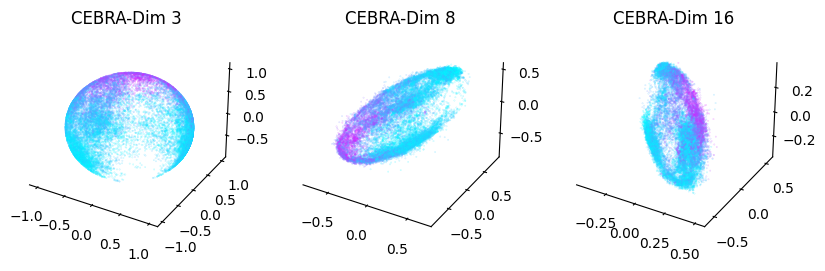

In [19]:
from matplotlib import pyplot as plt

embedding_labels=np.minimum(continuous_index[:, 0], continuous_index[:, 1], continuous_index[:, 2])

fig = plt.figure(figsize = (10,3), dpi = 100)
ax1 = plt.subplot(131,projection='3d')
ax1 = cebra.plot_embedding(ax=ax1, embedding=cebra_posdir3[:,:], embedding_labels=embedding_labels, cmap="cool")
ax2 = plt.subplot(132,projection='3d')
ax2 = cebra.plot_embedding(ax=ax2, embedding=cebra_posdir8[:,:], embedding_labels=embedding_labels, cmap="cool")
ax3 = plt.subplot(133,projection='3d')
ax3 = cebra.plot_embedding(ax=ax3, embedding=cebra_posdir16[:,:], embedding_labels=embedding_labels, cmap="cool")

ax1.set_title('CEBRA-Dim 3')
ax2.set_title('CEBRA-Dim 8')
ax3.set_title('CEBRA-Dim 16')
plt.savefig('./Figures-cebra/0719_BVC_Tri_trace_all_boundarydist')
plt.show()

In [12]:
def find_high_contributors(calcium_data, embedded_indices, n_top=10):  
    # Calculate z-scores for each timestep
    # Calcium data is already normalized
    cell_means = np.mean(calcium_data, axis=1)
    cell_stds = np.std(calcium_data, axis=1)
    z_scores = (calcium_data - cell_means[:, np.newaxis]) / cell_stds[:, np.newaxis]
    
    # Extract z-scores for embedded points of interest
    relevant_z_scores = z_scores[embedded_indices, :]
    
    # Aggregate contributions (using mean absolute z-score)
    mean_contributions = np.mean(np.abs(relevant_z_scores), axis=0)
    
    # Find top contributors
    top_contributors = np.argsort(mean_contributions)[::-1][:n_top]
    
    return top_contributors, mean_contributions

# Usage
threshold = np.percentile(embedding_labels, 70)
embedded_indices = np.argwhere(embedding_labels > threshold).flatten()
top_cells, contributions = find_high_contributors(total_trace, embedded_indices, 30)

/tmp/ipykernel_3914/1335203416.py:6: RuntimeWarning: invalid value encountered in divide
  z_scores = (calcium_data - cell_means[:, np.newaxis]) / cell_stds[:, np.newaxis]


In [13]:
print(top_cells)
# 5, 46, 30, 41, 46, 50, 67, 70

[72 35 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 18 17 16  7  1  2  3
  4  5  6  8 15  9]


In [20]:
# Normalize continuous_index to 0-1 range
def renormalize_angle(x):
    if x < 0:
        return x + 1
    else:
        return x - 1
    
# embedding_labels = np.array([renormalize_angle(x) for x in embedding_labels])
norm = plt.Normalize(embedding_labels.min(), embedding_labels.max())
normalized_index = norm(embedding_labels)

# Choose colormap ('cool' or 'viridis')
cmap = plt.get_cmap('plasma')  # or 'viridis'

# Get RGB values (0-1 range)
colors_float = cmap(normalized_index)[:, :3]

# Convert to 0-255 range for PLY file
colors = (colors_float * 255).astype(int)
print(colors)
# Function to write colored PLY file
def write_colored_ply(filename, points, colors):
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for point, color in zip(points, colors):
            f.write(f"{point[0]} {point[1]} {point[2]} {color[0]} {color[1]} {color[2]}\n")

# Write the colored PLY file
dim = 3
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir3, colors)
dim = 8
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir8, colors)
dim = 16
write_colored_ply(f"colored_points_{dim}.ply", cebra_posdir16, colors)

[[117   0 168]
 [112   0 168]
 [118   1 168]
 ...
 [248 150  63]
 [248 152  62]
 [251 162  56]]


In [44]:
shuffled_index = np.random.permutation(np.column_stack((x_pos, y_pos, head_dir)))
# index = (5, 46) #30, 41, 46, 50, 67, 70
# neural = total_trace[:, index] # 78, 50, 68, 84, 122, 133

shuffled_cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

shuffled_cebra_posdir3_model.fit(neural, shuffled_index)
shuffled_cebra_posdir3_model.save("models/shuffled_cebra_posdir3_model.pt")

shuffled_cebra_posdir8_model.fit(neural, shuffled_index)
shuffled_cebra_posdir8_model.save("models/shuffled_cebra_posdir8_model.pt")

shuffled_cebra_posdir16_model.fit(neural, shuffled_index)
shuffled_cebra_posdir16_model.save("models/shuffled_cebra_posdir16_model.pt")

pos: -0.7768 neg:  6.9961 total:  6.2192 temperature:  1.0000: 100%|██████████| 1000/1000 [02:09<00:00,  7.72it/s]
pos: -0.5450 neg:  6.7265 total:  6.1815 temperature:  1.0000: 100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]
pos: -0.4035 neg:  6.5941 total:  6.1906 temperature:  1.0000: 100%|██████████| 1000/1000 [02:59<00:00,  5.59it/s]


In [45]:
shuffled_cebra_posdir3_model = cebra.CEBRA.load("models/shuffled_cebra_posdir3_model.pt")
shuffled_cebra_posdir3 = shuffled_cebra_posdir3_model.transform(neural)

shuffled_cebra_posdir8_model = cebra.CEBRA.load("models/shuffled_cebra_posdir8_model.pt")
shuffled_cebra_posdir8 = shuffled_cebra_posdir8_model.transform(neural)

shuffled_cebra_posdir16_model = cebra.CEBRA.load("models/shuffled_cebra_posdir16_model.pt")
shuffled_cebra_posdir16 = shuffled_cebra_posdir16_model.transform(neural)

In [46]:
import ripser

maxdim=1 # set to 2 to compute up to H2. The computing time is considerably longer. 

np.random.seed(111)
random_idx=np.random.permutation(np.arange(len(cebra_posdir3)))[:1000]
topology_dimension = {}
for embedding in [cebra_posdir3, cebra_posdir8, cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_dimension[dimension] = ripser_output

In [47]:
np.random.seed(111)
topology_random_dimension = {}
for embedding in [shuffled_cebra_posdir3, shuffled_cebra_posdir8, shuffled_cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_random_dimension[dimension] = ripser_output

In [48]:
print(np.shape(np.asarray(topology_random_dimension[3]['dgms'][0])))

(1000, 2)


In [49]:
def plot_barcode(topology_result, maxdim):
    fig, axs = plt.subplots(maxdim+1, 1, sharex=True, figsize=(7, 8))
    axs[0].set_xlim(0,2)
    cocycle = ["Points", "Loops", "Voids"]
    for k in range(maxdim+1):
        bars = topology_result['dgms'][k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 6 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np
                              .linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)
    
    return fig 

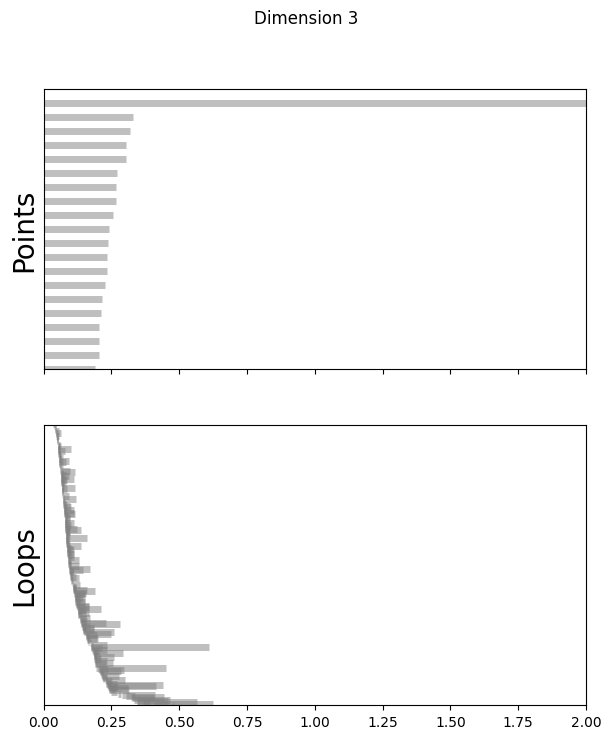

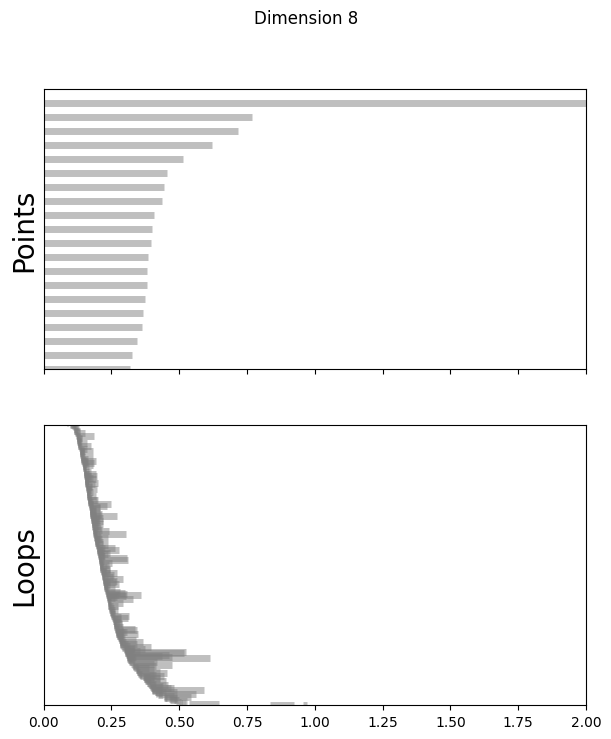

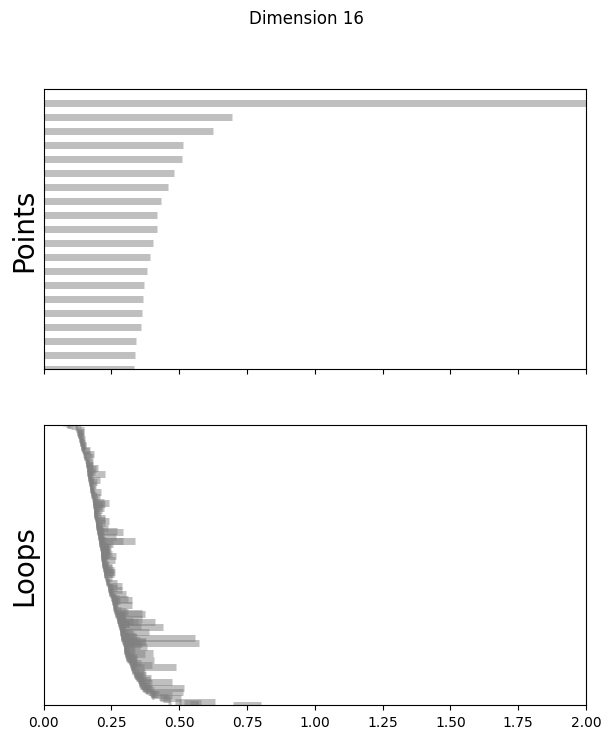

In [50]:
%matplotlib inline

for k in [3,8,16]:
    fig=plot_barcode(topology_dimension[k], maxdim)
    fig.suptitle(f'Dimension {k}')

In [32]:
np.shape(topology_random_dimension[3]['dgms'][0][:, 1])

(861,)

In [51]:
from persim import plot_diagrams

def read_lifespan(ripser_output, dim):
    dim_diff = ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
    if dim == 0:
        return dim_diff[~np.isinf(dim_diff)]
    else:
        return dim_diff

def get_max_lifespan(ripser_output_list, maxdim):
    lifespan_dic = {i: [] for i in range(maxdim+1)}
    for f in ripser_output_list:
        for dim in range(maxdim+1):
            lifespan = read_lifespan(f, dim)
            lifespan_dic[dim].extend(lifespan)
    return [max(lifespan_dic[i]) for i in range(maxdim+1)], lifespan_dic

def get_betti_number(ripser_output, shuffled_max_lifespan):
    bettis=[]
    for dim in range(len(ripser_output['dgms'])):
        lifespans=ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
        betti_d = sum(lifespans > shuffled_max_lifespan[dim] * 1.1)
        bettis.append(betti_d)
    return bettis

def plot_lifespan(topology_dgms, shuffled_max_lifespan, ax, label_vis, maxdim):
    plot_diagrams(
        topology_dgms,
        ax=ax,
        legend=True,
    )

    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[0], 2 + shuffled_max_lifespan[0]],
        color="C0",
        linewidth=3,
        alpha=0.5,

    )
    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[1], 2 + shuffled_max_lifespan[1]],
        color="orange",
        linewidth=3,
        alpha=0.5,

    )
    if maxdim == 2:
        ax.plot(
            [-0.50, 2],
            [-0.5 + shuffled_max_lifespan[2], 2 + shuffled_max_lifespan[2]],
            color="green",
            linewidth=3,
            alpha=0.5,
        )
    ax.set_xlabel("Birth", fontsize=15)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.tick_params(labelsize=13)
    if label_vis:
        ax.set_ylabel("Death", fontsize=15)
    else:
        ax.set_ylabel("")



In [ ]:
fig = plt.figure(figsize=(18,5))
for n, dim in enumerate([3,8,16]):
    shuffled_max_lifespan, lifespan_dic = get_max_lifespan(topology_random_dimension[dim], maxdim)
    ax = fig.add_subplot(1,3,n+1)
    ax.set_title(f'Dimension {dim}')
    plot_lifespan(topology_dimension[dim]['dgms'], shuffled_max_lifespan, ax, True, maxdim)
    print(f"Betti No. for dimension {dim}: {get_betti_number(topology_dimension[dim], shuffled_max_lifespan)}")